# Wildfire Risk - Model - Script-based Approach
__Team 3 - Dave Friesen, John Chen, and Kyle Dalope__<br>
__ADS-508-02-SP23__<br><br>
__GitHub link: https://github.com/davefriesen/wildfire-risk__

In [2]:
__authors__ = ['Dave Friesen', 'John Chen', 'Kyle Dalope']
__contact__ = ['dfriesen@sandiego.edu', 'johnchen@sandiego.edu', 'kdalope@sandiego.edu']
__date__ = '2023-03-20'
__license__ = 'MIT'
__version__ = '1.0.1'

In [3]:
cloud = True
%store cloud

Stored 'cloud' (bool)


# Setup

In [4]:
# Import basic libraries
if cloud:
    import boto3
    import sagemaker

# Import basic and data access libraries
import pandas as pd
from profiler import profile, profile_cat

# Import model and performance evaluation libraries
#pip install scikit-learn==1.0.0

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

# Import custom model library
from model_process import ModelProcess

# Import utility libraries
import copy

In [5]:
if cloud:
    # Establish session fundamentals
    sess = sagemaker.Session()
    bucket = sess.default_bucket()
    role = sagemaker.get_execution_role()
    region = boto3.Session().region_name
    account_id = boto3.Session().client(service_name='sagemaker', region_name=region)

    # Re-confirm public and private paths
    s3_public_path = 's3://wildfire-risk/'
    %store s3_public_path
    s3_private_path = 's3://{}/widfire-risk/csv/'.format(bucket)
    %store s3_private_path

    # Re-copy public bucket-based data to private (local) bucket
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'fires'/ --exclude '*' --include 'fires.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'weather'/ --exclude '*' --include 'weather.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'conditions'/ --exclude '*' --include 'conditions.csv'
    #!aws s3 cp --recursive $s3_public_path $s3_private_path'merged'/ --exclude '*' --include 'merged.csv'    

Stored 's3_public_path' (str)
Stored 's3_private_path' (str)


# Data Load

In [6]:
if cloud:
    df = pd.read_csv(s3_private_path+'merged/merged.csv', low_memory=False)
else:
    df = pd.read_csv('../data/merged.csv', low_memory=False)

# Data Profiling and Pre-Processing

## Target and Feature Identification (preliminary)

In [7]:
# Preliminarily elimate n/a features - in this case, extraneous from target 'fires' dataset
df = df.drop(columns=[
    'ContainmentDateTime',
    'ControlDateTime',
    'DiscoveryAcres',
    'EstimatedCostToDate',
    'FinalAcres',
    'FireCause',
    'FireBehaviorGeneral',
    'FireBehaviorGeneral1',
    'FireBehaviorGeneral2',
    'FireBehaviorGeneral3',
    'FireCauseGeneral',
    'FireCauseSpecific',
    'FireDiscoveryDateTime',
    'FireOutDateTime',
    'GACC',
    'IncidentName',
    'IncidentShortDescription',
    'InitialLatitude',
    'InitialLongitude',
    'IsFireCauseInvestigated',
    'IsTrespass',
    'POOCity',
    'POOState',
    'PredominantFuelModel',
    'PrimaryFuelModel',
    'ym_date'    
])

pd.set_option('display.max_rows', 100)
profile(df)

,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
STATION,object,42289,418,,,,,,,,,,USR0000CCRE__USR0000
LATITUDE,float64,42289,416,,,40.9,4.3,32.6,49.0,,,2407.7,37.745__40.1383__41.
LONGITUDE,float64,42289,409,,,-120.7,2.2,-124.3,-114.5,,,177.4,-118.9833__-123.8236
ELEVATION,float64,42289,332,,,1046.3,542.1,,2748.7,,,,2316.5__135.9__591.3
NAME,object,42289,418,,,,,,,,,,CRESTVIEW CALIFORNIA
CDSD,float64,39981,4742,2308,5.5,192.8,296.7,,3200.5,,,,0.0__107.5__428.3__2
CDSD_ATTRIBUTES,object,39577,1,2712,6.4,,,,,,,,U__U__U__U__U
CLDD,float64,42241,2473,48,0.1,38.3,69.0,,566.7,,,26.9,0.0__69.3__0.0__49.8
CLDD_ATTRIBUTES,object,42241,6,48,0.1,,,,,,,,",U__,U__,U__,U__,U"
DT00,float64,42279,15,10,,0.1,0.6,,17.0,14.6,,,0.0__0.0__0.0__0.0__


In [8]:
# Identify column types and feature set, including for pipeline treeatment
ignore_cols = ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME', 'geohash', 'year', 'month', 'PLT_CN',
               'STATE', 'LAT', 'LON', 'FireCause']

cat_nominal_cols = ['CDSD_ATTRIBUTES', 'CLDD_ATTRIBUTES', 'DT00_ATTRIBUTES', 'DT32_ATTRIBUTES',
                    'DX32_ATTRIBUTES', 'DX70_ATTRIBUTES', 'DX90_ATTRIBUTES', 'EMNT_ATTRIBUTES',
                    'EMXT_ATTRIBUTES', 'HDSD_ATTRIBUTES', 'HTDD_ATTRIBUTES', 'TAVG_ATTRIBUTES',
                    'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES']
cat_ordinal_cols = []
cat_binary_cols = []

num_interval_cols = ['COND_STATUS_CD']
num_ratio_cols = ['ELEVATION', 'CDSD', 'CLDD', 'DT00', 'DT32', 'DX32', 'DX70', 'DX90',
                  'EMNT', 'EMXT', 'HDSD', 'HTDD', 'TAVG', 'TMAX', 'TMIN', 'MAPDEN',
                  'STDAGE', 'STDSZCD', 'FLDSZCD', 'SITECLCD', 'SICOND', 'STDORGCD',
                  'SLOPE', 'PHYSCLCD', 'GSSTKCD', 'DSTRBCD1', 'TRTCD1', 'PRESNFCD',
                  'FLDAGE', 'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG',
                  'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG',
                  'WATERCD']

target_cls_col = ['fire']

reduce_X_cols = ignore_cols + target_cls_col

# Data Partitioning

In [9]:
df_X = df.loc[:, ~df.columns.isin(reduce_X_cols)].copy()
df_y = df[target_cls_col]

In [10]:
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=1-train_ratio, 
    random_state=42, stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=test_ratio/(test_ratio+val_ratio),
    random_state=42, stratify=y_test)

trows = df_X.shape[0]
print('\nTrain/validation/test: ', X_train.shape[0], '/', X_val.shape[0], '/', X_test.shape[0])

profile_cat(y_train, target_cls_col)


Train/validation/test:  29602 / 8458 / 4229

fire - 
0.0 76.991419
1.0 23.008581


# Modeling

## Model Setup (selection)

In [11]:
# Set feature cols for appropriate pipeline preprocessing
cat_cols = cat_nominal_cols + cat_ordinal_cols + cat_binary_cols  # one-hot encoding, imputing (if necc)
num_cols = num_interval_cols + num_ratio_cols  # scaling, imputing (if necc)

# Set model list
mp_queue = (
    (LogisticRegression(), {'random_state': 42}),
    (Perceptron(), {'class_weight': 'balanced'}),
    (LinearDiscriminantAnalysis(), None),
    (LinearSVC(), {'max_iter': 500}),

    (KNeighborsClassifier(), {'n_neighbors': 3}),
    (KNeighborsClassifier(), {'n_neighbors': 5}),
    (KNeighborsClassifier(), {'n_neighbors': 7}),

    (DecisionTreeClassifier(), {'max_depth': 4, 'random_state': 42}),
    (DecisionTreeClassifier(), {'max_depth': 5, 'random_state': 42}),

    (RandomForestClassifier(), {'max_depth': 4, 'random_state': 42}),
    (RandomForestClassifier(), {'max_depth': 5, 'random_state': 42}),

    (AdaBoostClassifier(), {'n_estimators': 10, 'random_state': 42}),

    (MLPClassifier(), {'random_state': 42}),
)

## Model Run and Evaluation (iteration n)

In [12]:
ModelProcess.show_progress = True

# Iterate models (note use of 'copy' is to preserve mutable elements
#   of model_queue tuple for possible later use)
mp_df = pd.DataFrame(mp_queue, columns=['algorithm', 'params'])
mp_df['mp'] = mp_df.apply(
    lambda mp: ModelProcess(copy.deepcopy(mp['algorithm']), None,
                            copy.copy(mp['params']),
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            None,
                            cat_cols, num_cols).train_validate_test(), axis=1)

# Compile, sort, and display results
mp_df[['train_acc', 'train_f1', 'train_time',
       'val_acc', 'val_f1', 'val_time',
       'test_acc', 'test_f1', 'test_time']] =\
    mp_df['mp'].apply(
        lambda mp: sum(list(map(
            lambda dataset: mp.score[dataset] + [mp.time[dataset]], ['train', 'val', 'test'])), [])).tolist()
mp_df.sort_values(by=['train_acc', 'val_acc', 'test_acc'],
                  ascending=[False, False, False], inplace=True)
#mp_df.loc[:, mp_df.columns != 'mp'].to_csv('results_table.csv')    

LogisticRegression: train... done in 5.42s.
LogisticRegression: val... done in 0.24s.
LogisticRegression: test... done in 0.14s.
Perceptron: train... done in 1.22s.
Perceptron: val... done in 0.12s.
Perceptron: test... done in 0.07s.
LinearDiscriminantAnalysis: train... done in 11.95s.
LinearDiscriminantAnalysis: val... done in 0.24s.
LinearDiscriminantAnalysis: test... done in 0.15s.
LinearSVC: train... done in 6.48s.
LinearSVC: val... done in 0.12s.
LinearSVC: test... done in 0.07s.
KNeighborsClassifier: train... done in 73.95s.
KNeighborsClassifier: val... done in 17.76s.
KNeighborsClassifier: test... done in 8.60s.
KNeighborsClassifier: train... done in 72.80s.
KNeighborsClassifier: val... done in 21.26s.
KNeighborsClassifier: test... done in 9.93s.
KNeighborsClassifier: train... done in 74.01s.
KNeighborsClassifier: val... done in 20.76s.
KNeighborsClassifier: test... done in 11.72s.
DecisionTreeClassifier: train... done in 1.75s.
DecisionTreeClassifier: val... done in 0.14s.
Deci

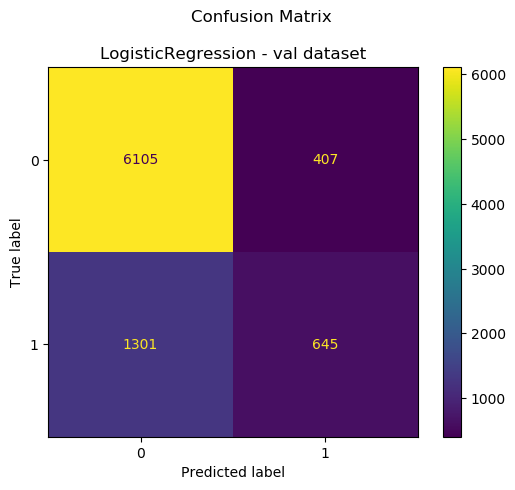



LogisticRegression - val dataset

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88      6512
         1.0       0.61      0.33      0.43      1946

    accuracy                           0.80      8458
   macro avg       0.72      0.63      0.65      8458
weighted avg       0.78      0.80      0.77      8458



In [13]:
# Show confusion matrix and summary for Logistic Regression
mp_df.loc[0]['mp'].confusion_matrix('val')
mp_df.loc[0]['mp'].summary('val')

In [14]:
# Show top features for Logistic Regression (this could be 'baked' into the
#   ModelProcess() class or similar in future)
model = mp_df.loc[0]['mp'].model
features = mp_df.loc[0]['mp'].pipe['preprocessor'].transformers_[0][1]['onehotencoder'].get_feature_names_out(cat_cols)
fi = pd.concat([pd.DataFrame(features, columns=['feature']),
                pd.DataFrame(num_cols, columns=['feature'])],
               ignore_index=True)

fi['importance'] = model.coef_[0]
fi['abs_importance'] = abs(fi['importance'])
fi.sort_values(by=['abs_importance', 'feature'],
               ascending=[False, True], inplace=True)
fi[fi['abs_importance'] >= 0.50][['feature', 'importance']]

,feature,importance
281,"EMXT_ATTRIBUTES_,U,20,+",-1.286978
263,"EMXT_ATTRIBUTES_,U,11,+",1.196588
130,"EMNT_ATTRIBUTES_1,U,14,",1.185592
253,"EMXT_ATTRIBUTES_,U,06,+",1.112852
99,"EMNT_ATTRIBUTES_,U,29,",1.088742
271,"EMXT_ATTRIBUTES_,U,15,+",-1.086021
90,"EMNT_ATTRIBUTES_,U,24,+",-0.930312
320,"EMXT_ATTRIBUTES_1,U,11,",0.913523
245,"EMXT_ATTRIBUTES_,U,02,+",0.898473
430,"EMXT_ATTRIBUTES_3,U,31,",0.860498


In [15]:
mp_df

,algorithm,params,mp,train_acc,train_f1,train_time,val_acc,val_f1,val_time,test_acc,test_f1,test_time
12,MLPClassifier(),{'random_state': 42},<model_process.ModelProcess object at 0x7f3bd8...,0.997433,0.994415,126.711754,0.894774,0.775366,0.293281,0.904469,0.796165,0.163525
4,KNeighborsClassifier(),{'n_neighbors': 3},<model_process.ModelProcess object at 0x7f3bd8...,0.923890,0.832801,73.952772,0.855167,0.687101,17.759814,0.848664,0.674466,8.601669
5,KNeighborsClassifier(),{'n_neighbors': 5},<model_process.ModelProcess object at 0x7f3bd8...,0.893284,0.759827,72.804675,0.849846,0.662951,21.256706,0.847245,0.660358,9.932449
6,KNeighborsClassifier(),{'n_neighbors': 7},<model_process.ModelProcess object at 0x7f3bd8...,0.877745,0.720346,74.006817,0.848546,0.651618,20.760017,0.845826,0.647568,11.723325
8,DecisionTreeClassifier(),"{'max_depth': 5, 'random_state': 42}",<model_process.ModelProcess object at 0x7f3bd8...,0.802750,0.438935,1.808683,0.793805,0.420213,0.160432,0.797825,0.424242,0.081048
0,LogisticRegression(),{'random_state': 42},<model_process.ModelProcess object at 0x7f3bd8...,0.797007,0.429291,5.418718,0.798061,0.430287,0.244850,0.805628,0.459921,0.141731
3,LinearSVC(),{'max_iter': 500},<model_process.ModelProcess object at 0x7f3bd8...,0.796568,0.396351,6.478755,0.795342,0.388987,0.121494,0.806810,0.438488,0.074987
2,LinearDiscriminantAnalysis(),None,<model_process.ModelProcess object at 0x7f3bd8...,0.795115,0.454341,11.947600,0.795105,0.448265,0.241186,0.805391,0.484013,0.146397
7,DecisionTreeClassifier(),"{'max_depth': 4, 'random_state': 42}",<model_process.ModelProcess object at 0x7f3bd8...,0.785589,0.347084,1.750224,0.778316,0.332503,0.143879,0.786238,0.334315,0.080720
11,AdaBoostClassifier(),"{'n_estimators': 10, 'random_state': 42}",<model_process.ModelProcess object at 0x7f3bd8...,0.776198,0.399420,4.814297,0.776070,0.402900,0.317014,0.787420,0.433522,0.161538


# Store Variables and Close Session

In [16]:
# Store variables for subsequent notebooks
%store

Stored variables and their in-db values:
cloud                                                 -> True
experiment_name                                       -> 'Amazon-Customer-Reviews-BERT-Experiment-167986154
ingest_create_athena_db_passed                        -> True
ingest_create_athena_table_parquet_passed             -> True
ingest_create_athena_table_passed                     -> True
ingest_create_athena_table_tsv_passed                 -> True
s3_private_path                                       -> 's3://sagemaker-us-east-1-074876746575/widfire-ris
s3_private_path_tsv                                   -> 's3://sagemaker-us-east-1-074876746575/amazon-revi
s3_public_path                                        -> 's3://wildfire-risk/'
s3_public_path_tsv                                    -> 's3://amazon-reviews-pds/tsv'
setup_dependencies_passed                             -> True
setup_iam_roles_passed                                -> True
setup_instance_check_passed        

In [17]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [18]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>